# Import Libraries

In [9]:
%run libs.ipy

# Reading Data

In [10]:
X_train, y_train = get_raw_data()

Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.


# PipeLine

In [11]:
imputer = ColumnTransformer([
    ('drop_features', 'drop', ['fecha','fecha_h','DART (MXN/MWh)','DARTbin','mda','mtr','mda52','mtr52']),
    ('impute_mean', SimpleImputer(strategy='mean'), ['temperatura', 'demanda']),
], remainder='passthrough', verbose_feature_names_out=False)
encoder = ColumnTransformer([
    ('ord_enc', OrdinalEncoder(categories=[['03DEC-230', '06FAI-400','07JOV-230']], handle_unknown='use_encoded_value', unknown_value=3), ['clanodo'])
    #('one_hot', OneHotEncoder(handle_unknown='ignore'), ['class of worker', 'education', 'sex'])
    #('one_hot2', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=["object_"]).columns.to_list()[9:13])
], remainder='passthrough', verbose_feature_names_out=False)
scalar = ColumnTransformer([
    ('robust', RobustScaler(), ['eolica', 'fotovol'])
], remainder='passthrough', verbose_feature_names_out=False)

In [12]:

datapipe = Pipeline(steps=[
 
    ('imputer', imputer),
    ('df1', MatrixToDataFrame(imputer)),
    ('encoder', encoder),
    ('df2', MatrixToDataFrame(encoder)),
    ('scalar', scalar),
    ('df3', MatrixToDataFrame(scalar))
])


In [13]:
X_tr = datapipe.fit_transform(X_train)

# Creating Data Frame for a node

In [14]:
node=0
DF_node=X_tr[X_tr['clanodo']==node];X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57609 entries, 0 to 57608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   eolica       57609 non-null  float64
 1   fotovol      57609 non-null  float64
 2   clanodo      57609 non-null  float64
 3   temperatura  57609 non-null  float64
 4   demanda      57609 non-null  float64
 5   festivo      57609 non-null  float64
 6   mes          57609 non-null  float64
 7   diaSemana    57609 non-null  float64
 8   hora         57609 non-null  float64
 9   mda7         57609 non-null  float64
 10  mtr7         57609 non-null  float64
 11  ypast7       57609 non-null  float64
 12  festivo7     57609 non-null  float64
 13  mda14        57609 non-null  float64
 14  mtr14        57609 non-null  float64
 15  ypast14      57609 non-null  float64
 16  festivo14    57609 non-null  float64
 17  ypast52      57609 non-null  float64
 18  festivo52    57609 non-null  float64
 19  ypas

# Visualizing DART

<Figure size 432x288 with 1 Axes>

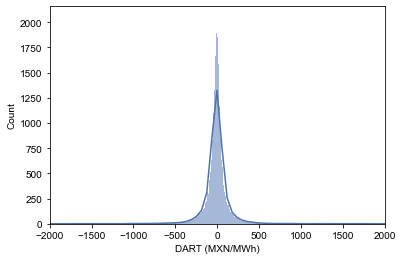

In [15]:
fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(16, 8)})
sns.histplot(data=X_train, x='DART (MXN/MWh)', kde=True)
ax.set_xlim(-2000, 2000)
plt.show()

# The data is balanced

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 576x288 with 1 Axes>

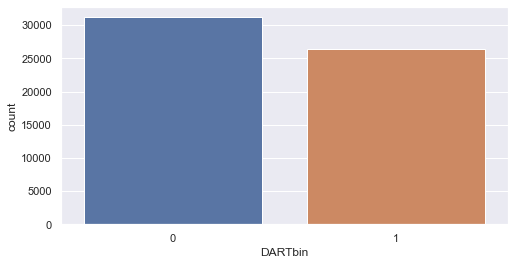

In [16]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.countplot(X_train['DARTbin'])
plt.show()

# Creating Train and Test Data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_train, test_size=0.33)

# Dummy Model

In [18]:
dc = DummyClassifier(strategy='uniform').fit(X_train, y_train)
yhat_dc = dc.predict(X_test)
accuracy_score(y_test, yhat_dc), precision_score(y_test, yhat_dc), recall_score(y_test, yhat_dc)

(0.49955289043185525, 0.4562578484721641, 0.5024199124222171)

# Default Models

In [19]:
candidates = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier]
accuracies = np.zeros(len(candidates))
precision = np.zeros(len(candidates))
recall = np.zeros(len(candidates))
for i, Model in enumerate(candidates):
    model = Model().fit(X_train, y_train)
    yhat = model.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    prec = precision_score(y_test, yhat)
    rec = recall_score(y_test, yhat)
    accuracies[i] = acc
    precision[i] = prec
    recall[i] = rec
for i, c in enumerate(candidates):
    print(c.__name__,"acc: ",accuracies[i])
    print(c.__name__,"prec: ",precision[i])
    print(c.__name__,"recc: ",recall[i])

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:06:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LogisticRegression acc:  0.583136079112093
LogisticRegression prec:  0.5628023352793995
LogisticRegression recc:  0.3887992625028808
DecisionTreeClassifier acc:  0.8205249592341276
DecisionTreeClassifier prec:  0.8021574477851733
DecisionTreeClassifier recc:  0.8054851348236921
RandomForestClassifier acc:  0.8868549786965441
RandomForestClassifier prec:  0.8893926739052619
RandomForestClassifier recc:  0.8589536759622033
XGBClassifier acc:  0.8015359528693914
XGBClassifier prec:  0.80066200809121
XGBClassifier recc:  0.7525927633095183


<Figure size 576x288 with 1 Axes>

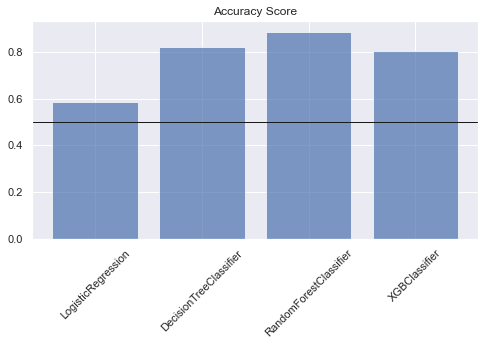

In [20]:
plt.bar([c.__name__ for c in candidates], accuracies, alpha=0.7)
plt.xticks(rotation=45)
plt.axhline(y=0.5001, linewidth=1, color='k')
plt.title("Accuracy Score");

Text(0.5, 1.0, 'Precision Score')

<Figure size 576x288 with 1 Axes>

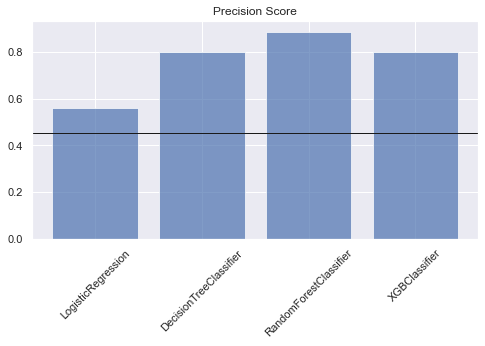

In [21]:
plt.bar([c.__name__ for c in candidates], precision,  alpha=0.7)
plt.xticks(rotation=45)
plt.axhline(y=0.4556, linewidth=1, color='k')
plt.title("Precision Score")

Text(0.5, 1.0, 'Recall Score')

<Figure size 576x288 with 1 Axes>

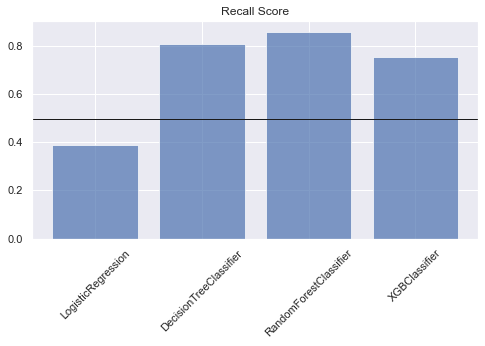

In [22]:
plt.bar([c.__name__ for c in candidates], recall, alpha=0.7)
plt.xticks(rotation=45)
plt.axhline(y=0.4972, linewidth=1, color='k')
plt.title("Recall Score")

# GridSearch XGBoost

In [23]:
parameters = {
    'max_depth': range (2, 32, 4),
    'n_estimators': [5,15,50],
    'learning_rate': [0.3, 0.01]
}
model = XGBClassifier(use_label_encoder =False)
gs = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=1, scoring = 'f1')
gs.fit(X_train, y_train)
gs.best_score_, gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[19:12:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.8576783599900913, {'learning_rate': 0.3, 'max_depth': 26, 'n_estimators': 50})

# Final XGBoost Model

In [24]:
finalmodel = XGBClassifier(learning_rate = 0.3, max_depth = 26 , n_estimators = 50)
finalmodel.fit(X_train, y_train)
y_hat = finalmodel.predict(X_test)
f1_score(y_test, y_hat)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8764371153176168

In [25]:
 accuracy_score(y_test, y_hat),precision_score(y_test, y_hat),recall_score(y_test, y_hat), f1_score(y_test, y_hat)

(0.8880648045868181, 0.8833099250936329, 0.869670430974879, 0.8764371153176168)

# Confusion matrixPrecision 

<Figure size 576x288 with 2 Axes>

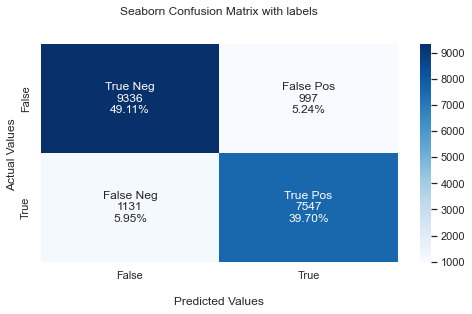

In [26]:
#plot_confusion_matrix(finalmodel,X_test,y_test)
cf_matrix = confusion_matrix(y_test, y_hat)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Thresold anaylisis

In [27]:
y_proba = finalmodel.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
best_thresh = best_thresh
best_thresh

0.3931171

display = PrecisionRecallDisplay.from_estimator(
    finalmodel, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [29]:
y_pred_adj = (finalmodel.predict_proba(X_test)[:,1] >= 0.25).astype(bool) 
precision_score(y_test,y_pred_adj),accuracy_score(y_test,y_pred_adj),recall_score(y_test,y_pred_adj)

(0.8228068379568021, 0.8752827310504445, 0.9262502880848121)

# ROC Curve (mi lap no puede instalar esto)

In [31]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.roc_curve import roc_curve
from roc_curve import roc_curve

#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           #n_clusters_per_class=2, n_samples=1000)
#X_train, X_test, y_train, y_test = train_test_split(X, y)

#model = LogisticRegression()
#model.fit(X_train, y_train)
#probabilities = model.predict_proba(X_test)[:, 1]
probabilities = finalmodel.predict_proba(X_test)[:,1]
              
tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.show()

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ C:\Users\x_cha\AppData\Local\Temp/ipykernel_24800/4186394161.py:5 in <module>             │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ 'C:\\Users\\x_cha\\AppData\\Local\\Temp/ipykernel_24800/4186394161.py'                    │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'src'

# Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 576x288 with 1 Axes>

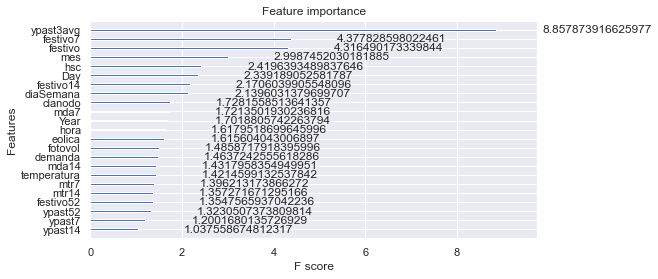

In [32]:
xgb.plot_importance(finalmodel,importance_type='gain')

# Exporting XGBoost final model

In [33]:
import pickle
with open('model.p', 'wb') as f:
    pickle.dump(finalmodel, f, protocol=pickle.HIGHEST_PROTOCOL
)